In [1]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as transforms

from scikitplot.metrics import confusion_matrix
import itertools

import yaml
import seaborn as sns
sns.set()
import time

import torch.nn as nn
import torch.nn.functional as F

In [2]:
from numpy.random import seed
seed(45)
torch.manual_seed(45)

In [5]:
train_dir = './train'
shutil.copytree('flowers',train_dir)

'./train'

In [6]:
valid_dir = './validation'

In [7]:
t_ratio = 0.7
_, dirs, _ = next(os.walk(train_dir))
images_perclass = np.zeros(5)

for i in range(len(images_perclass)):
    path = os.path.join(train_dir,dirs[i])
    files = np.asarray(os.listdir(path))
    images_perclass[i] = len(files)

In [8]:
val_counter = np.round(images_perclass*(1-t_ratio))

In [9]:
for i in range(len(images_perclass)):
    source_path = os.path.join(train_dir, dirs[i])
    dest_path = os.path.join(valid_dir, dirs[i])
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    files = np.asarray(os.listdir(source_path))
    for j in range(int(val_counter[i])):
        dst = os.path.join(dest_path, files[j])
        src = os.path.join(source_path, files[j])
        shutil.move(src,dst)

In [3]:
transform = transforms.Compose([
    transforms.Resize(256), # we'll work with images of size 256 x 256
    transforms.CenterCrop(256),
    transforms.RandomRotation(25), # randomly rotate images by 25 degrees
    transforms.RandomHorizontalFlip(), # randomly flip images horizontally
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5] ) #normalize images for efficient training
    ])
batch = 16
batch_size = 4

In [10]:
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=valid_dir, transform=transform)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4) 

In [11]:
classes = ['diasy', 'dandelion', 'rose', 'sunflower','tulip']

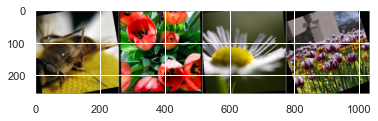

diasy tulip diasy tulip


In [12]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [79]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 18, 5)
        self.fc1 = nn.Linear(18*61*61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [100]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [84]:
from tqdm import tqdm
start_time = int(time.time())

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 5 00 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

end_time = int(time.time())

fl1_time = end_time-start_time
print(fl1_time)

Finished Training
Finished Training
1417


In [86]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fl1_acc = 100 * correct // total
print(f'Accuracy of the network on the  test images: {fl1_acc} %')

Accuracy of the network on the 10000 test images: 67 %


In [87]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: diasy is 76.4 %
Accuracy for class: dandelion is 71.8 %
Accuracy for class: rose  is 57.4 %
Accuracy for class: sunflower is 73.2 %
Accuracy for class: tulip is 53.2 %


In [88]:
# Saving the model
PATH = './fl1.pth'
torch.save(net.state_dict(), PATH)

In [13]:
import torch.nn as nn

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(64,128,3)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,3)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,512,3)
        self.bnorm4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512,1024,3)
        self.bnorm5 = nn.BatchNorm2d(1024)
        self.fc1 = nn.Linear(1024 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256,5)

    def forward(self, x):
        x = self.pool(self.bnorm1(F.leaky_relu(self.conv1(x))))
        x = self.pool(self.bnorm2(F.leaky_relu(self.conv2(x))))
        x = self.pool(self.bnorm3(F.leaky_relu(self.conv3(x))))
        x = self.pool(self.bnorm4(F.leaky_relu(self.conv4(x))))
        x = self.pool(self.bnorm5(F.leaky_relu(self.conv5(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.fc6(x)
        return x


net2 = Net2()


In [16]:

from torch.optim import Adam
from torch.autograd import Variable


optimizer=Adam(net2.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()


In [ ]:
from tqdm import tqdm
start_time = int(time.time())

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')

end_time = int(time.time())

fl2_time = end_time-start_time
print(fl2_time)

In [58]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fl2_acc = 100 * correct // total
print(f'Accuracy of the network on the  test images: {fl2_acc} %')

Accuracy of the network on the  test images: 57 %


In [56]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net2(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: diasy is 0.0 %
Accuracy for class: dandelion is 0.0 %
Accuracy for class: rose  is 1.8 %
Accuracy for class: sunflower is 51.4 %
Accuracy for class: tulip is 51.4 %


In [112]:
# Saving the model
PATH = './fl2.pth'
torch.save(net2.state_dict(), PATH)

In [ ]:
fl1 = fl1_acc
fl2 = fl2_acc

bar_width = 0.25
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(fl1))
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]
 
# Make the plot
plt.bar(br1, fl1, color ='r', width = bar_width,
        edgecolor ='grey', label ='model 1')
plt.bar(br2, fl2, color ='g', width = bar_width,
        edgecolor ='grey', label =' model 2')
 
# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + bar_width for r in range(len(fl1))],
        ['acc','loss'])

plt.legend()
plt.show()

In [ ]:
times = [fl1_time,fl2_time]
models = ['model 1','model 2']
# Make the plot
plt.bar(models,times,width = 0.4)

# Adding Xticks
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Training Time', fontweight ='bold', fontsize = 15)
plt.title("Comparison of training times",fontsize = 18)
plt.legend()
plt.show()